### Run XGBoost on AWS to speed things along
##### adapted from run_xgboost_models.py

In [15]:
import cPickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

import xgboost as xgb

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc

from nltk import word_tokenize
from nltk.stem import snowball, porter, wordnet
#SnowballStemmer, porter.PorterStemmer, wordnet.WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Function Definitions

In [2]:
def load_data(filename = 'labeledhate_5cats.p'):
    '''
    Load data into a data frame for use in running model
    '''
    return pickle.load(open(filename, 'rb'))

In [3]:
def splitdata(df, classes, test_size=0.3):
    '''
    Split data into test & train; binarizes y into 5 classes
    Outputs: X_train, X_test, y_train, y_test
    '''
    X = df.body
    y = df.label

    #relabel y labels to reflect integers [0-4] for xgboost
    for ind in range(len(classes)):
        y[(y==classes[ind])] = int(ind)

    return train_test_split(X, y, test_size=test_size, random_state=42)

def stem_tokens(tokens, stemmer):
    stemmed=[]
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [4]:
def vectorizer(vectchoice = 'Count', stopwords = 'english', tokenize_me = None, max_features=500):
    '''
    Choose/return sklearn vectorizer, from Count Vectorizer, TFIDF, HashingVectorizer
    Choose from: stopwords: ['english' or 'None'],
                vectorizer = ['Count', 'Hash' or 'Tfidf']
                tokenize_me: [None or tokenize]
    '''

    if vectchoice == 'Count':
        vect = CountVectorizer(stop_words=stopwords, decode_error='ignore',
                                tokenizer = tokenize_me, max_features=max_features)

    # class sklearn.feature_extraction.text.CountVectorizer(input='content', encoding='utf-8',
    # decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None,
    # stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word',
    # max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False,
    # dtype=<class 'numpy.int64'>)[source]¶



    elif vectchoice == "Hash":
        vect = HashingVectorizer(stop_words=stopwords, decode_error = 'ignore',
                                    non_negative=True, tokenizer = tokenize_me)

    # class sklearn.feature_extraction.text.HashingVectorizer(input='content', encoding='utf-8',
    # decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None,
    #  stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word',
    #  n_features=1048576, binary=False, norm='l2', non_negative=False, dtype=<class 'numpy.float64'>)[source]



    elif vectchoice == 'Tfidf':
        vect = TfidfVectorizer(stop_words=stopwords, decode_error='ignore',
                                tokenizer = tokenize_me,max_features=max_features)


    # class sklearn.feature_extraction.text.TfidfVectorizer(input='content', encoding='utf-8',
    # decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None,
    # analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1),
    # max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>
    # , norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶


    # fit & transform train vector
    vectfit_train = vect.fit_transform(X_train)
    # transform test vector
    vectfit_test = vect.transform(X_test)

    return vectfit_train, vectfit_test

In [5]:
def print_scores(y_test, y_score, y_preds):
    '''
    Print model performance stats.
    y_test: test labels (sklearn format); y_score: probabilities; y_preds: predictions
    '''
    print("ROC AUC Score: {0}".format(roc_auc_score(y_test, y_score)))
    # print("Classification report: {0}".format(classification_report(y_test, y_preds)))

def top_features(d, n=20):
    '''
    Function to show the top n important features & their scores.
    The get_fscore method in xgboost returns a dictionary of features & a number.
    Get the top n features with the highest scores

    d is a dictionary (from get_fscore method in xgboost)
    '''

    featureslist = []

    for k, v in sorted(d.iteritems(), reverse=True, key=lambda (k,v): (v,k)):
        featureslist.append((k,v))

    return featureslist[:n]

In [13]:
def createmulticlassROC(classes, y_test, y_score):
    '''
    Function to create & plot ROC curve & associated areas
    Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    Inputs: classes: a list of classes
            y_test: the test labels, binarized into columns
            y_score: the predicted probabilities for each class.
                (e.g. y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test) )
    '''

    # Compute ROC curve and ROC area for each class
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize = (12,8))
#   plt.figure()

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for multi-class')
    plt.legend(loc="lower right")
    plt.show()

#### Main block equivalent

In [7]:
classes = ['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']

print("Loading Data")
df = load_data()
print("Splitting Data")
X_train, X_test, y_train, y_test = splitdata(df, classes)

#relabel the output for multiclass roc plot, score
ylabel_bin = label_binarize(y_test.astype(int), classes=[0,1,2,3,4],sparse_output=False)

Loading Data
Splitting Data


Options entered; loop starting
For vect Tfidf, stemmer <nltk.stem.snowball.SnowballStemmer object at 0x7f52e6a15c90> & token <function tokenize at 0x7f52ec0618c0>
Vectorizing
Classifying

[0]	train-merror:0.305857	test-merror:0.304485
[1]	train-merror:0.301198	test-merror:0.300288
[2]	train-merror:0.296273	test-merror:0.295791
[3]	train-merror:0.293085	test-merror:0.292975



predicting, classification error=0.291127


[4]	train-merror:0.290902	test-merror:0.291127


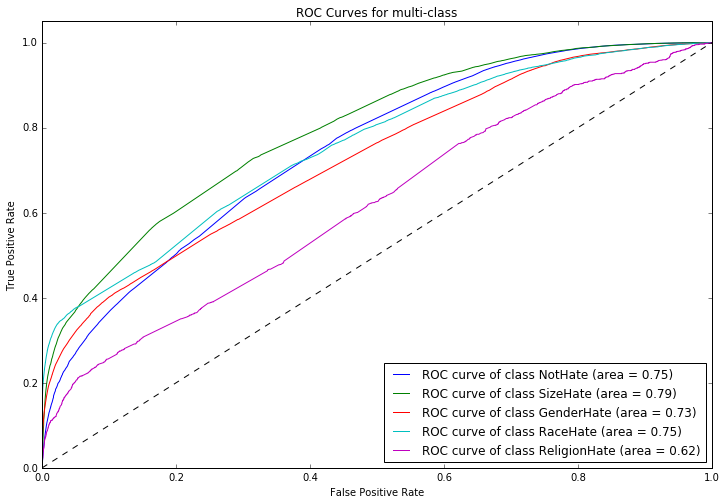

ROC AUC Score: 0.727100642308
 
For vect Tfidf, stemmer <nltk.stem.snowball.SnowballStemmer object at 0x7f52e6a15c90> & token <function tokenize at 0x7f52ec0618c0>
Vectorizing
Classifying

[0]	train-merror:0.302515	test-merror:0.301048
[1]	train-merror:0.295338	test-merror:0.294340
[2]	train-merror:0.290864	test-merror:0.290210
[3]	train-merror:0.287884	test-merror:0.287490



predicting, classification error=0.285415


[4]	train-merror:0.285400	test-merror:0.285415


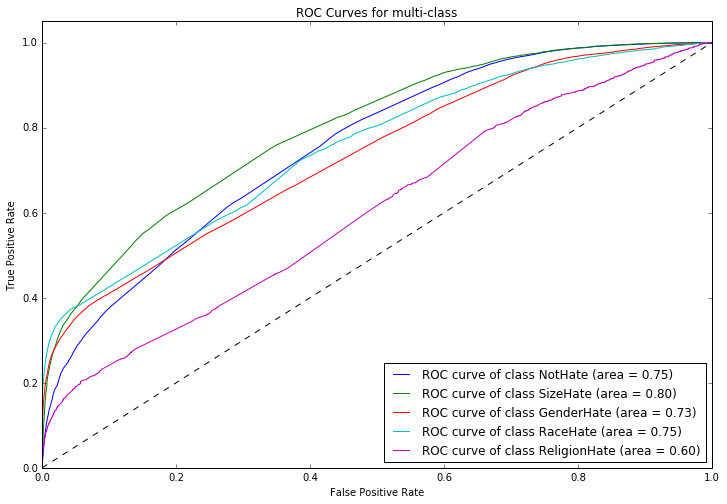

ROC AUC Score: 0.727518878611
 
For vect Tfidf, stemmer <nltk.stem.snowball.SnowballStemmer object at 0x7f52e6a15c90> & token <function tokenize at 0x7f52ec0618c0>
Vectorizing
Classifying

[0]	train-merror:0.303317	test-merror:0.301918
[1]	train-merror:0.295350	test-merror:0.294156
[2]	train-merror:0.289244	test-merror:0.288482
[3]	train-merror:0.284671	test-merror:0.284368



predicting, classification error=0.281305


[4]	train-merror:0.281466	test-merror:0.281305


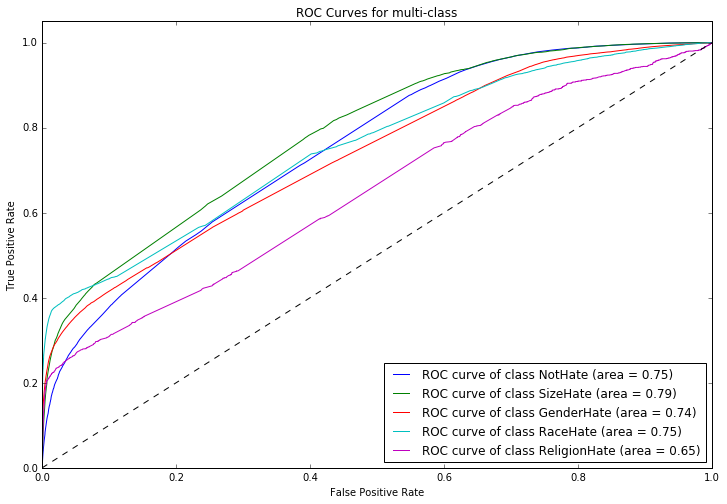

ROC AUC Score: 0.735319456566
 


In [ ]:
### Loop through # max_features? --> Use 5000 as a starting point, at least for now. ###
### Use english stop words

# vect_options = ['Count', 'Hash', 'Tfidf']
vect_options = ['Tfidf']

# token_options = [None, tokenize]
token_options = [tokenize]

stemmer = snowball.SnowballStemmer("english")
n_max_features = [1000, 2000, 10000]

print("Options entered; loop starting")

for token in token_options:
    for fnum in n_max_features:
        for vect in vect_options:
            print('For vect {0}, stemmer {1} & token {2}'.format(vect, stemmer, token))
            print('Vectorizing')
            vectfit_X_train, vectfit_X_test = vectorizer(vectchoice = vect,
                        stopwords = 'english', tokenize_me = token, max_features=fnum)
            print('Classifying')
            xg_train = xgb.DMatrix(vectfit_X_train, label=y_train)
            xg_test = xgb.DMatrix(vectfit_X_test, label=y_test)
            # Set up xboost parameters
            param = {}
            # use softmax multi-class classification
            # param['objective'] = 'multi:softmax'
            # scale weight of positive examples
            param['eta'] = 0.9
            param['max_depth'] = 6
            param['silent'] = 0
#             param['nthread'] = 8 # Comment out -- default is max # threads available
            param['num_class'] = 5

            watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
            num_round = 5
            # bst = xgb.train(param, xg_train, num_round, watchlist )
            param['objective'] = 'multi:softprob'
            bst = xgb.train(param, xg_train, num_round, watchlist );
            # get prediction, this is in 1D array, need reshape to (ndata, nclass)
            yprob = bst.predict(xg_test).reshape(y_test.shape[0], 5)
            ylabel = np.argmax(yprob, axis=1)

            print('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))
            createmulticlassROC(classes, ylabel_bin, yprob)
            print("ROC AUC Score: {0}".format(roc_auc_score(ylabel_bin, yprob)))

#             top_features(bst.get_fscore(), n=20)
            print(' ')

In [ ]:
### Use english stop words

# vect_options = ['Count', 'Hash', 'Tfidf']
vect_options = ['Count']

# token_options = [None, tokenize]
token_options = [tokenize]

stemmer = snowball.SnowballStemmer("english")
n_max_features = [1000, 2000, 10000]

print("Options entered; loop starting")

for token in token_options:
    for fnum in n_max_features:
        for vect in vect_options:
            print('For vect {0}, stemmer {1} & token {2}'.format(vect, stemmer, token))
            print('Vectorizing')
            vectfit_X_train, vectfit_X_test = vectorizer(vectchoice = vect,
                        stopwords = 'english', tokenize_me = token, max_features=fnum)
            print('Classifying')
            xg_train = xgb.DMatrix(vectfit_X_train, label=y_train)
            xg_test = xgb.DMatrix(vectfit_X_test, label=y_test)
            # Set up xboost parameters
            param = {}
            # use softmax multi-class classification
            # param['objective'] = 'multi:softmax'
            # scale weight of positive examples
            param['eta'] = 0.9
            param['max_depth'] = 6
            param['silent'] = 0
#             param['nthread'] = 8 # Comment out -- default is max # threads available
            param['num_class'] = 5

            watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
            num_round = 5
            # bst = xgb.train(param, xg_train, num_round, watchlist )
            param['objective'] = 'multi:softprob'
            bst = xgb.train(param, xg_train, num_round, watchlist );
            # get prediction, this is in 1D array, need reshape to (ndata, nclass)
            yprob = bst.predict(xg_test).reshape(y_test.shape[0], 5)
            ylabel = np.argmax(yprob, axis=1)

            print('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))
            createmulticlassROC(classes, ylabel_bin, yprob)
            print("ROC AUC Score: {0}".format(roc_auc_score(ylabel_bin, yprob)))

#             top_features(bst.get_fscore(), n=20)
            print(' ')